# Import Libraries Used

In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Utilities.plot import histvstarget, distribution

# Import and preprocess the data

Remember from the data exploration notebook that we now have three different data sets now, the original, one with PCA and one with attribute selection using BFE.

First lets take 20% of the data out to be used as a validation set and create the three different training-sets from the rest.

In [6]:
trainingdata_org = pd.read_csv('input/Train.csv')
cols = trainingdata_org.columns
trainingdata_org = trainingdata_org.dropna(axis=0)
ground_truth = trainingdata_org['Outcome']
trainingdata_org = trainingdata_org.drop(['Outcome'], axis=1)
x_train_un, x_val_un, y_train, y_val = train_test_split(trainingdata_org, ground_truth, 
                                                        test_size=0.1, random_state = 22)

meantrain = np.mean(x_train_un)
stdtrain = np.std(x_train_un)
standardize = lambda x: ((x - meantrain)/stdtrain)
invstandardize = lambda x: ((x*stdtrain + meantrain))


x_train = standardize(x_train_un)
x_val = standardize(x_val_un)

trainingdata = pd.DataFrame(np.hstack((x_train, y_train[:,np.newaxis])), columns = cols)
validationdata = pd.DataFrame(np.hstack((x_val, y_val[:,np.newaxis])), columns = cols)
trainingdata.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-0.718725,-0.458883,-2.602080,-1.034028,-0.299577,-1.420212,-0.357932,-0.475749,0.0
1,-0.718725,1.346738,0.887502,1.259767,-0.738378,-0.040065,-0.546374,1.828328,0.0
2,-1.026751,0.099218,1.204736,-0.208262,-0.299577,-0.808394,-0.049572,-0.955766,0.0
3,1.437451,-1.607915,-0.064202,0.984511,-0.887404,0.315643,0.492914,0.772293,0.0
4,1.437451,-0.754349,0.253032,0.984511,0.486951,0.899004,0.367286,1.156306,1.0


In [7]:
# Dataset with PCA
import Utilities.mypca as PCA
pca = PCA.MyPCA()
pca.fit(x_train)
PCA_x_train = pca.fit_transform(5, x_train)
PCA_x_val = pca.fit_transform(5, x_val)
print(PCA_x_train.shape)

(315, 5)


In [8]:
BFE_cols = ["Glucose", "Pregnancies", "BMI", "SkinThickness", "Insulin", "BloodPressure"]
BFE_x_train = trainingdata[BFE_cols]
BFE_x_val = validationdata[BFE_cols]
print(BFE_x_train.shape)

(315, 6)


# Comparing models with K-fold cross validation using accuracy

Since our dataset is small the best way to approach it is probably by using shallow learners. 

Lets establish a baseline for the problem by using cross validation and a few classification models. If we use k-fold cross validation since our dataset is quite small a splitting of our data into to few folds could introduce a substantial bias. On the other hand if we chose k to large we will have a lot of variance. With the small data-set in the back of out head we chose k to be moderately large, 18.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [10]:
LR = LogisticRegression()
GB = GaussianNB() # Gaussian NB since we have continous data.
KN = KNeighborsClassifier(n_neighbors=4, p = 2) # 4 Neighbors by euclidian distance.
DT_GINI = DecisionTreeClassifier(criterion="gini",max_depth=4) # Decision Tree with Gini impurity for quality of split
DT_IG = DecisionTreeClassifier(criterion="entropy",max_depth=4) # Information gain for quality of split
SV = SVC() # Support vector machine classifier.

modelnames = ["Logistic regression","Gaussian Naive Bayes", "4-Neighbors","Decisiontree Gini",
              "Decisiontree Information gain", "Support vector machine"]

models = zip(modelnames,[LR, GB, KN, DT_GINI, DT_IG, SV])
results_PCA = []
results_BFE = []
results = []

for name,model in models:
    kfold = KFold(n_splits=18)
    cv_result_PCA = cross_val_score(model, PCA_x_train, y_train, cv = kfold,scoring = "accuracy")
    cv_result_BFE = cross_val_score(model, BFE_x_train, y_train, cv = kfold,scoring = "accuracy")
    cv_result = cross_val_score(model, x_train, y_train, cv = kfold,scoring = "accuracy")
    results_PCA.append(cv_result_PCA)
    results_BFE.append(cv_result_BFE)
    results.append(cv_result)

print("PCA")
for name, res in zip(modelnames, results_PCA):
    print(name,res.mean())
print()
print("BFE")
for name, res in zip(modelnames, results_BFE):
    print(name,res.mean())
print()
print("All Data")
for name, res in zip(modelnames, results):
    print(name,res.mean())

PCA
Logistic regression 0.785039941903
Gaussian Naive Bayes 0.762345679012
4-Neighbors 0.727850399419
Decisiontree Gini 0.761982570806
Decisiontree Information gain 0.73311546841
Support vector machine 0.736746550472

BFE
Logistic regression 0.765976761075
Gaussian Naive Bayes 0.771604938272
4-Neighbors 0.73311546841
Decisiontree Gini 0.744734931009
Decisiontree Information gain 0.756717501816
Support vector machine 0.7558097313

All Data
Logistic regression 0.781771968046
Gaussian Naive Bayes 0.775417574437
4-Neighbors 0.736746550472
Decisiontree Gini 0.730573710966
Decisiontree Information gain 0.762164124909
Support vector machine 0.774872912128


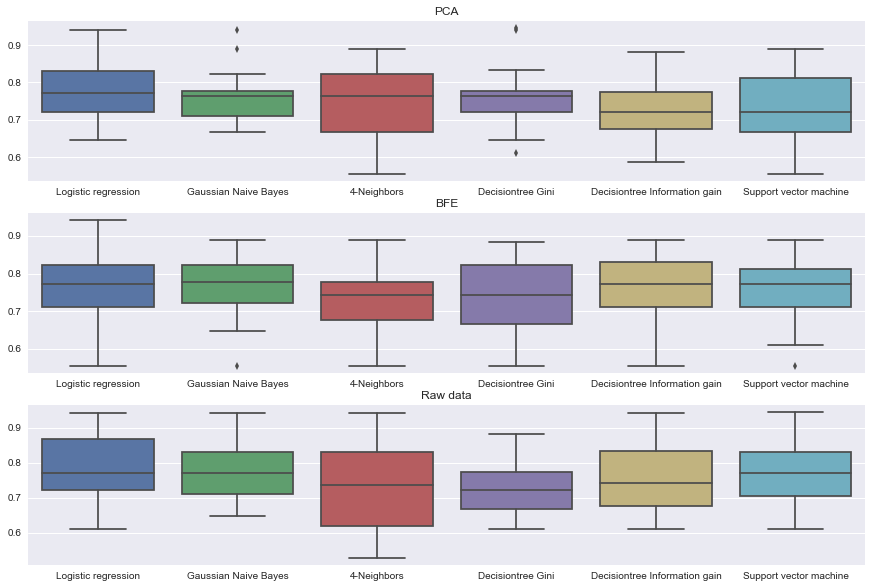

In [17]:
f, ax = plt.subplots(figsize=(15,10))
plt.subplot(3, 1, 1)
ax = sns.boxplot(data=results_PCA)
ax.set_title("PCA")
ax.set_xticklabels(modelnames)

plt.subplot(3, 1, 2)
ax = sns.boxplot(data=results_BFE)
ax.set_title("BFE")
ax.set_xticklabels(modelnames)

plt.subplot(3, 1, 3)
ax = sns.boxplot(data=results)
ax.set_xticklabels(modelnames)
ax.set_title("Raw data")
plt.savefig('modelsvsdata.eps', format='eps', dpi=1000)

Still no sign of significantly better accuracy for any of the data sets, different models perform differently across the datasets. Logistic regression seems to be the best performing model. 

# Confusion Matrixes and validation data

Since k-fold-cross validation did not give us any clear information, lets have a look at the confusion matrixes and accuracy on the validation data for the different models.

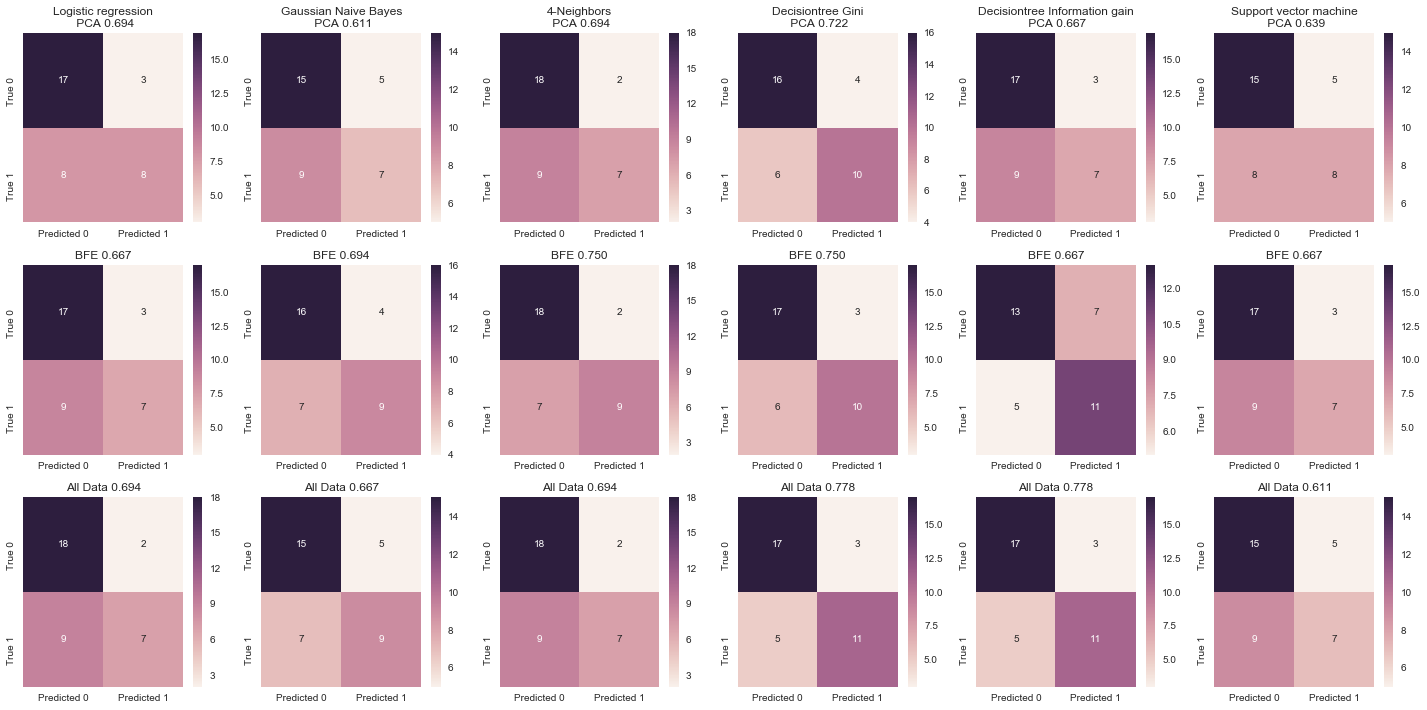

In [60]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

models = zip(modelnames,[LR, GB, KN, DT_GINI, DT_IG, SV])

i=1
xlabel = ["Predicted 0","Predicted 1"]
ylabel = ["True 0","True 1"]
plt.figure(figsize=(20, 10))

for name, model in models:
    model.fit(PCA_x_train, y_train)
    predictions=model.predict(PCA_x_val)
    conf_PCA = (confusion_matrix(y_val,predictions))
    plt.subplot(3, 6, i)
    sns.heatmap(conf_PCA, annot=True, xticklabels=xlabel, yticklabels=ylabel)    
    acc = (accuracy_score(y_val,predictions))
    plt.title(name + "\n PCA " + '{0:.{1}f}'.format(acc, 3))
    model.fit(BFE_x_train, y_train)
    predictions=model.predict(BFE_x_val)
    conf_BFE = (confusion_matrix(y_val,predictions))
    plt.subplot(3, 6, i+6)
    sns.heatmap(conf_BFE, annot=True, xticklabels=xlabel, yticklabels=ylabel)  
    acc = (accuracy_score(y_val,predictions))
    plt.title("BFE " + '{0:.{1}f}'.format(acc, 3))
    model.fit(x_train, y_train)
    predictions=model.predict(x_val)
    conf = (confusion_matrix(y_val,predictions))
    plt.subplot(3, 6, i+12)
    sns.heatmap(conf, annot=True, xticklabels=xlabel, yticklabels=ylabel)  
    acc = (accuracy_score(y_val,predictions))
    plt.title("All Data " + '{0:.{1}f}'.format(acc, 3))
    i = i + 1

plt.tight_layout()
plt.savefig('confusion.eps', format='eps', dpi=1000)

Look at that, apparently almost all models predict the unseen validation badly. The model that classifies the validation set significantly better is the decision trees. As we inspect the confusion matrix we note that most of the models have almost identical predictions when it comes to instances with true negative outcomes. Where they differ and where some of the the decision trees is superior is when we try to predict true positive outcomes. Many of the models are worse than random guessing. So why is this? It's called the False positive paradox. Basically since the majority of the instances has outcome not diabetes our models will favor predicting not diabetes. 

In [9]:
print("Number of training instances with outcome diabetes", np.count_nonzero(y_train))
print("Number of training instances with outcome not diabetes", len(y_train)-np.count_nonzero(y_train))

Number of training instances with outcome diabetes 102
Number of training instances with outcome not diabetes 213


This leads to another paradox, namely the accuracy paradox. Basically it means that because of the inbalance in outcomes predictive models with a given certain accuracy might have greater predicitve capablility than a model with higher accuracy. For example, a model with a 1:10 ratio between postitive and negtive outcomes, say 15 and 150. Predicting everything as negative gives us

In [10]:
example_train = [1 if i%10==0 else 0 for i in range(150)]
prediction = [0 for i in range(len(example_train))]
print("An accuracy of", accuracy_score(example_train,prediction))

An accuracy of 0.9


Our completely useless model with zero predictive power have 90% accuracy. In our data the inbalance is not as sever but the moral remains. Hence we exchange accuracy as metric in favour of AUC - The area under the ROC (receiver operating characteristic) curve. The ROC curve is the true positive rate (TPR) against the false positive rate (FPR) at various thresholds/ranks for the instances. The area under the curve measures discrimination, the ability to correctly classify those with and without diabetes in our case. An simple interpretation is the following: consider if we randomly draw one person that has diabetes and one without, the person with high ranking (or low) should be the one with diabetes. The area under the curve is the percentage of randomly drawn pairs for which this is true.

In [19]:
from sklearn.metrics import roc_auc_score

print("PCA AUC")
for name, model in zip(modelnames,[LR, GB, KN, DT_GINI, DT_IG, SV]):
    model.fit(PCA_x_train, y_train)
    predictions=model.predict(PCA_x_val)
    roc = (roc_auc_score(y_val,predictions))
    print(name, roc)
    
print("\nBFE AUC")
for name, model in zip(modelnames,[LR, GB, KN, DT_GINI, DT_IG, SV]):
    model.fit(BFE_x_train, y_train)
    predictions=model.predict(BFE_x_val)
    roc = (roc_auc_score(y_val,predictions))
    print(name, roc)

print("\nAll data AUC")
for name, model in zip(modelnames,[LR, GB, KN, DT_GINI, DT_IG, SV]):
    model.fit(x_train, y_train)
    predictions=model.predict(x_val)
    roc = (roc_auc_score(y_val,predictions))
    print(name, roc)

PCA AUC
Logistic regression 0.675
Gaussian Naive Bayes 0.59375
4-Neighbors 0.66875
Decisiontree Gini 0.7125
Decisiontree Information gain 0.64375
Support vector machine 0.625

BFE AUC
Logistic regression 0.64375
Gaussian Naive Bayes 0.68125
4-Neighbors 0.73125
Decisiontree Gini 0.7375
Decisiontree Information gain 0.66875
Support vector machine 0.64375

All data AUC
Logistic regression 0.66875
Gaussian Naive Bayes 0.65625
4-Neighbors 0.66875
Decisiontree Gini 0.8
Decisiontree Information gain 0.8
Support vector machine 0.59375


 Inspecting the confusion matrixes and AUC scores we note that the absolutely best model is the decision tree with gini impurity or entropy and using all the data, hence that is the model we'll move on with. This is good in the sense that interpretability is available, somethinng that might be important.

# Optimizing the decision tree

As familiar decision trees have high variance. As such we now look at the effect of increasing the maximum depth of the tree and at the same time inspeting the deviation of 100 trees at that depth. The maximum leaf nodes is fixed to avoid overfitting.

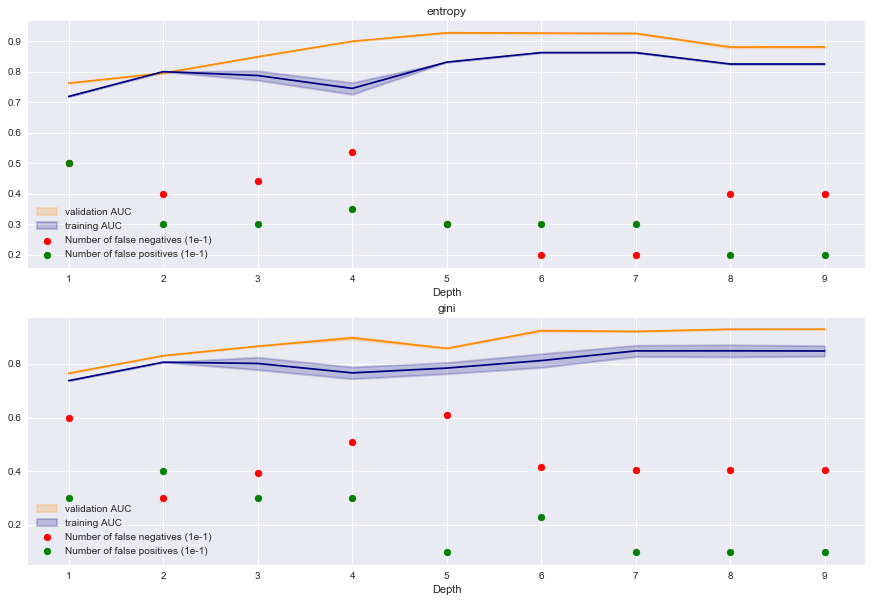

In [31]:
from sklearn.metrics import roc_auc_score
def exploredepth(cr, max_leaf_nodes):
    depth = np.arange(1,10,1)
    t = []
    v = []
    stdt = []
    stdv = []
    conf = []
    falpos = []
    falneg = []
    for i in depth:
        train_loss = []
        val_loss = []
        conf = []
        conf2 = []
        for j in range(1,100):
            model = DecisionTreeClassifier(criterion=cr, splitter='best', 
                                       max_depth=i, min_samples_split=2, min_samples_leaf=1, 
                                       min_weight_fraction_leaf=0.0, max_features=None, random_state=None, 
                                       max_leaf_nodes=max_leaf_nodes, min_impurity_split=1e-07, 
                                           class_weight=None, presort=False)
            model.fit(x_train, y_train)
            val_loss.append((roc_auc_score(y_val,model.predict(x_val))))
            train_loss.append((roc_auc_score(y_train,model.predict(x_train))))
            c = confusion_matrix(y_val,model.predict(x_val))
            conf.append(c[1][0])
            conf2.append(c[0][1])
        falpos.append(np.mean(conf))
        falneg.append(np.mean(conf2))
        t.append(np.mean(train_loss))
        stdt.append(np.std(train_loss))
        v.append(np.mean(val_loss))
        stdv.append(np.std(val_loss))
    lw = 2
    plt.plot(depth,t,color="darkorange")
    tp =plt.fill_between(depth, np.array(t) - np.array(stdt),
                     np.array(t) + np.array(stdt), alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(depth,v,color = "navy")
    vp = plt.fill_between(depth, np.array(v) - np.array(stdv),
                     np.array(v) + np.array(stdv), alpha=0.2,
                     color="navy", lw=lw)
    fp = plt.scatter(depth, np.array(falpos)/10.0, color="red")
    fn = plt.scatter(depth, np.array(falneg)/10.0, color="green")
    plt.legend((tp,vp,fp,fn),
               ['validation AUC','training AUC','Number of false negatives (1e-1)','Number of false positives (1e-1)']
               , loc='lower left')
    plt.xlabel('Depth')

plt.figure(figsize=(15, 10))
plt.subplot(2,1,1)
plt.title('entropy')
exploredepth('entropy', 25)

plt.subplot(2,1,2)
plt.title('gini')
exploredepth('gini', 25)
plt.savefig('xploredepth.eps', format='eps', dpi=1000)

The plot does not imply any overfitting, by inspection the best model is the decision tree with entropy criterion using a leaf node bound of 25, and depth bound of 6. 

## Parameter search

To do a more rigorus parameter search we're gonna search an selected subset of the parameters.

In [34]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import zero_one_loss, f1_score
from Utilities.utils import gridsearch

model = DecisionTreeClassifier() # Our model
param_grid = {"max_depth": np.arange(2,8,1), # Maximum depth of tree
              "max_features": np.arange(3,8,1), # Number of features to consider when looking for the best split
              "max_leaf_nodes": np.arange(4,27,1), # Maximum number of leaves in our tree.
              "criterion": ["gini", "entropy"], # Splitting criteria
              "class_weight": [None, 'balanced',{0: 1.105, 1: 1.15}] # Weights associated with classes.
            }

metric = roc_auc_score # Metric to use
tiebreaker = zero_one_loss # Tie breaker metric.
n_best_grids = 10 # 5 best grids

best_score, best_grid, tiebreaker = gridsearch(model, x_train, y_train, x_val, y_val, param_grid, metric, 
                                               n_best_grids, loss=False, tiebreaker=tiebreaker)

        
for a,t,g in zip(best_score, tiebreaker, best_grid):
    print("AUC:",a) 
    print("Tie",t)
    print("Grid:",g)

AUC: 0.8875
Tie 0.111111111111
Grid: {'max_depth': 7, 'max_leaf_nodes': 19, 'class_weight': {0: 1.105, 1: 1.15}, 'criterion': 'gini', 'max_features': 7}
AUC: 0.8875
Tie 0.111111111111
Grid: {'max_depth': 7, 'max_leaf_nodes': 26, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 6}
AUC: 0.88125
Tie 0.138888888889
Grid: {'max_depth': 7, 'max_leaf_nodes': 20, 'class_weight': None, 'criterion': 'gini', 'max_features': 7}
AUC: 0.88125
Tie 0.111111111111
Grid: {'max_depth': 7, 'max_leaf_nodes': 14, 'class_weight': {0: 1.105, 1: 1.15}, 'criterion': 'gini', 'max_features': 5}
AUC: 0.88125
Tie 0.111111111111
Grid: {'max_depth': 7, 'max_leaf_nodes': 23, 'class_weight': None, 'criterion': 'gini', 'max_features': 6}
AUC: 0.88125
Tie 0.138888888889
Grid: {'max_depth': 7, 'max_leaf_nodes': 21, 'class_weight': None, 'criterion': 'gini', 'max_features': 6}
AUC: 0.88125
Tie 0.138888888889
Grid: {'max_depth': 6, 'max_leaf_nodes': 22, 'class_weight': None, 'criterion': 'entropy', 'max_f

[[19  1]
 [ 4 12]]


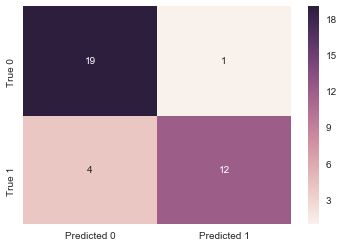

In [41]:
model.set_params(**best_grid[0])
model.fit(x_train,y_train)
c = confusion_matrix(y_val,model.predict(x_val))
sns.heatmap(c, annot=True, xticklabels=xlabel, yticklabels=ylabel) 
print(c)

This seems like a good result and we could naively choose this single tree, or any of the top 10 combinations as they have the same error, as our model. The problem is that every time we run the parameter search another combination of parameters will be the best tree because of the intrinsic variance of decison trees, additionally these trees will have a really good error as well because of the natural low bias of decision trees. Remember that the trees are tuned to the validation set and might, probably wont, generalize good to new data.

But there is some pattern to what sort of combinations work for the problem. For the entropy criterion trees the best performing ones the maximum depth is between 5 and 7, the maximum number of leaves between 22 and 26, the maximum number of features to consider on each split around 7 and using balanced weighting for the classes. The balanced weighting adjust the weights for the classes inversely proportional to class frequencies, basically counteracting the false positive hypothesis mentioned earlier. 

For the gini criterion trees the best performing ones the maximum depth is around 7, the maximum number of leaves varies alot but tend to approach higher values (≈25), the maximum number of features to consider on each split around 7 and using the propoced weighting for the classes.

To decrease variance and try to make our model to generalize we use need to use an esemble. The first that comes to mind is trying Bootstrap aggregating or a random forest. It should theoretically provide the stability we need and reduces variance.

# Ensembles

0.7125


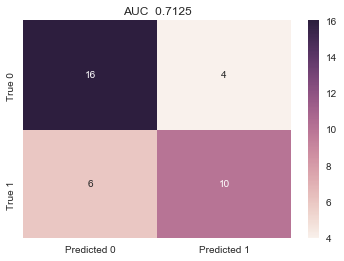

In [52]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
base = DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                       max_depth=5, min_samples_split=2, min_samples_leaf=1, 
                                       min_weight_fraction_leaf=0.0, max_features=None, random_state=None, 
                                       max_leaf_nodes=22, min_impurity_split=1e-07, 
                                           class_weight='balanced', presort=False)

model = BaggingClassifier(base_estimator=base, n_estimators=100, max_samples=1.0, max_features=1.0, 
                  bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, 
                  n_jobs=1, random_state=None, verbose=0)
model.fit(x_train, y_train)
predictions = model.predict(x_val)
conf = (confusion_matrix(y_val,predictions))
auc = (roc_auc_score(y_val,predictions))
sns.heatmap(conf, annot=True, xticklabels=xlabel, yticklabels=ylabel)
plt.title("AUC  " + str(auc))
print(auc)
plt.savefig('Bagging.eps', format='eps', dpi=1000)

0.675


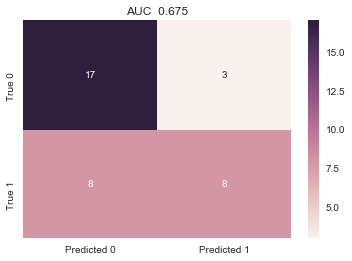

In [53]:
model = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=5, 
                       min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                       max_features='auto', max_leaf_nodes=22, min_impurity_split=1e-07, 
                       bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, 
                       warm_start=False, class_weight=None)
model.fit(x_train, y_train)
predictions = model.predict(x_val)
conf = (confusion_matrix(y_val,predictions))
auc = (roc_auc_score(y_val,predictions))
sns.heatmap(conf, annot=True, xticklabels=xlabel, yticklabels=ylabel)
plt.title("AUC  " + str(auc))
print(auc)
plt.savefig('randfor.eps', format='eps', dpi=1000)

The esembles seems to provide stablility and decrease the variance run to run. However they seem to introduce some bias. Looking back at when we compared entropy and gini criterion and looked at the effect of the depth and variance. Remeber that the gini trees generally had few false positives while entropy trees had few false negatives. An viable hypothesis might be that the two complement eachother, and because we in the esembles above only use the one or the other. To test the hypothesis we're gonna try an VotingClassifier using the parameters search result we aquired above. 

The voting classifier consists of a 5:4 ratio of entropy and gini trees since the gini trees showed less potential in the grid search. The classification is done using a majority vote rule.

0.8875
0.929370339685


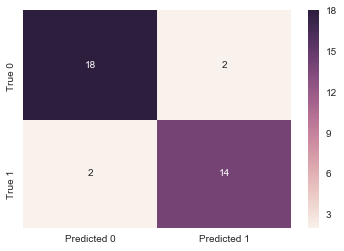

In [56]:
from sklearn.ensemble import VotingClassifier
mods = []
for i in range(1,100): # 100 Trees provides low variance.
    # A parameter combination that were sucessfull for entropy trees.
    mods.append((str(i),DecisionTreeClassifier(criterion='entropy', splitter='best', 
                               max_depth=5, min_samples_split=2, min_samples_leaf=1, 
                               min_weight_fraction_leaf=0.0, max_features=None, random_state=None, 
                               max_leaf_nodes=22, min_impurity_split=1e-07, class_weight='balanced', presort=False)))
    if(i < 80):
        # A parameter combination that were sucessfull for gini trees.
        mods.append((str(i)+"gi",DecisionTreeClassifier(criterion='gini', splitter='best', 
                               max_depth=7, min_samples_split=2, min_samples_leaf=1, 
                               min_weight_fraction_leaf=0.0, max_features=None, random_state=None, 
                               max_leaf_nodes=25, min_impurity_split=1e-07, 
                                                        class_weight={0: 1.105, 1: 1.15}, presort=False)))
model = VotingClassifier(estimators=mods, voting='hard', n_jobs=1)
model.fit(x_train, y_train)
predictions = model.predict(x_val)
conf = (confusion_matrix(y_val,predictions))
auc = (roc_auc_score(y_val,predictions))
sns.heatmap(conf, annot=True, xticklabels=xlabel, yticklabels=ylabel)
print(auc)
print((roc_auc_score(y_train,model.predict(x_train))))

The hypothesis might be true, this is a really good seperation and a AUC of nearly 89 for the validation set and 93 for the training set. Thats not a gigantic difference and hopefully the constraints on the trees have prevented the model from overfitting on the training data.

# Pipeline

Before giving the test set a go we train our model on the entire training dataset with some imputing. We also put it into a pipeline to automate the workflow.

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer,StandardScaler
X = pd.read_csv('input/Train.csv')
Y = X['Outcome']
X = X.drop(["Outcome"], axis=1)

model = VotingClassifier(estimators=mods, voting='hard', n_jobs=1)
pipeline = Pipeline([("imputer", Imputer(missing_values='NaN',
                                          strategy="mean",
                                          axis=0)),
                      ("standardizer", StandardScaler()),
                      ("VotingClassifier", model)])
pipeline.fit(X,Y)

Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('VotingClassifier', VotingClassifier(estimators=[('1', DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
 ...sort=False, random_state=None, splitter='best'))],
         n_jobs=1, voting='hard', weights=None))])

# Test

## No missing values

accuracy 0.878048780488
AUC 0.889367816092


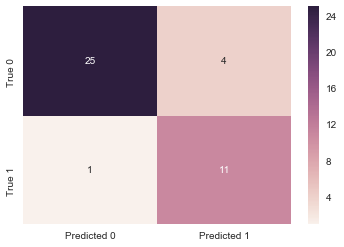

In [59]:
test = pd.read_csv('input/Test.csv')
test.dropna(inplace = True)
truth = test['Outcome']
test.drop('Outcome', axis = 1, inplace = True)
predictions = pipeline.predict(test)
conf = (confusion_matrix(truth,predictions))
acc = (accuracy_score(truth,predictions))
auc = (roc_auc_score(truth,predictions))
sns.heatmap(conf, annot=True, xticklabels=xlabel, yticklabels=ylabel)  
print("accuracy", acc)
print("AUC", auc)
plt.savefig('test_conf.eps', format='eps', dpi=1000)

Eureka, this is really good. 

## Missing values

accuracy 0.792207792208
AUC 0.794230769231


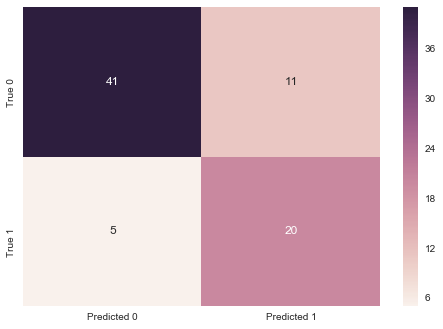

In [449]:
test = pd.read_csv('input/Test.csv')
truth = test['Outcome']
test.drop('Outcome', axis = 1, inplace = True)
predictions = pipeline.predict(test)
conf = (confusion_matrix(truth,predictions))
acc = (accuracy_score(truth,predictions))
auc = (roc_auc_score(truth,predictions))
sns.heatmap(conf, annot=True, xticklabels=xlabel, yticklabels=ylabel)  
print("accuracy", acc)
print("AUC", auc)

Not as good, but still good.